In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import warnings

from scipy.signal import savgol_filter
from pygam import LinearGAM, s
from shapely.geometry import Point
from tqdm.notebook import trange, tqdm

projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围

warnings.simplefilter("ignore")  # 忽略警告信息

In [2]:
def plot_stretch_map(ax, data, title, vmin, vmax, cmap='Blues', extend=None, log_axis=False, alpha=1.0):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    cmap = plt.get_cmap(cmap)
    img = ax.imshow(data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
    ax.set_title(title, fontsize=12)
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05, extend=extend)
    cbar.ax.tick_params(labelsize=10)

# 绘制GCM评估结果

## 偏差矫正前，全球平均，各气候模式的tas/pr/pet时间序列，与cru时间序列

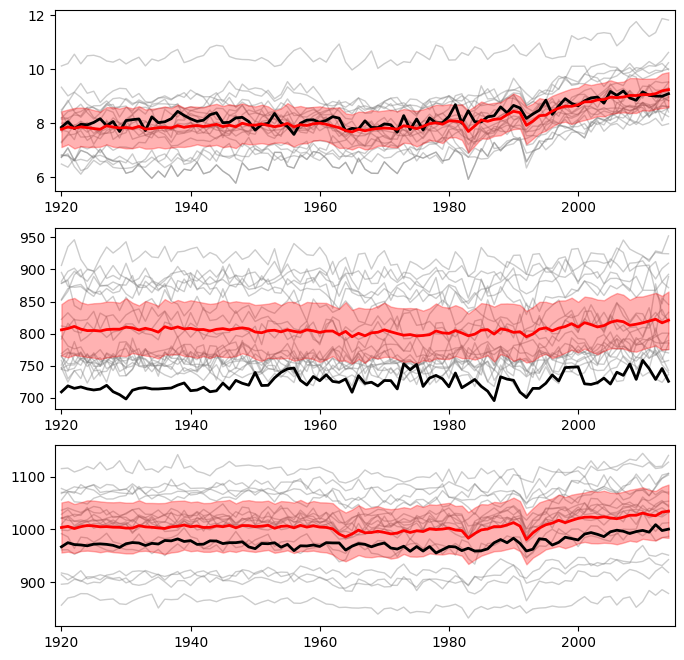

In [12]:
# 读取cru数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series.resample('YS').sum()
cru_series = cru_series['1920-01-01' : '2014-12-31']

# 读取gcm数据
pr_gcm  = pd.read_csv("../data/global_mean_series/gcm_ds/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
tas_gcm = pd.read_csv("../data/global_mean_series/gcm_ds/tas/tas_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').mean()
pet_gcm = pd.read_csv("../data/global_mean_series/gcm_ds/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
pet_gcm = pet_gcm.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])

pr_gcm  = pr_gcm['1920-01-01' : '2014-12-31']
tas_gcm = tas_gcm['1920-01-01' : '2014-12-31']
pet_gcm = pet_gcm['1920-01-01' : '2014-12-31']

pr_gcm_mean  = pr_gcm.mean(axis=1)
tas_gcm_mean = tas_gcm.mean(axis=1)
pet_gcm_mean = pet_gcm.mean(axis=1)
pr_gcm_std   = pr_gcm.std(axis=1)
tas_gcm_std  = tas_gcm.std(axis=1)
pet_gcm_std  = pet_gcm.std(axis=1)

scale_range = 0.7

fig, ax = plt.subplots(3, 1, figsize=(8, 8))

ax[0].plot(cru_series.index.year, cru_series['tas'] / 12, color='black', label='CRU', linewidth=2)
ax[0].plot(tas_gcm_mean.index.year, tas_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[0].plot(tas_gcm.index.year, tas_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[0].fill_between(tas_gcm_mean.index.year, tas_gcm_mean - scale_range * tas_gcm_std, tas_gcm_mean + scale_range * tas_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[0].set_xlim(1919, 2015)

ax[1].plot(cru_series.index.year, cru_series['pr'], color='black', label='CRU', linewidth=2)
ax[1].plot(pr_gcm_mean.index.year, pr_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[1].plot(pr_gcm.index.year, pr_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[1].fill_between(pr_gcm_mean.index.year, pr_gcm_mean - scale_range * pr_gcm_std, pr_gcm_mean + scale_range * pr_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[1].set_xlim(1919, 2015)

ax[2].plot(cru_series.index.year, cru_series['pet'], color='black', label='CRU', linewidth=2)
ax[2].plot(pet_gcm_mean.index.year, pet_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[2].plot(pet_gcm.index.year, pet_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[2].fill_between(pet_gcm_mean.index.year, pet_gcm_mean - scale_range * pet_gcm_std, pet_gcm_mean + scale_range * pet_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[2].set_xlim(1919, 2015)

plt.savefig("../images/gcm_assessment_bc/global_historical_mean_series_ds.pdf")

## 偏差矫正前，全球格点，多年平均，多模式平均tas/pr/pet与cru的偏差地图

In [59]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

gcm_pr  = np.load("../data/mme/pr_ds/pr_historical_ds_mme.npy", mmap_mode='r')
gcm_tas = np.load("../data/mme/tas_ds/tas_historical_ds_mme.npy", mmap_mode='r')
gcm_pet = np.load("../data/mme/pet_ds/pet_historical_ds_mme.npy", mmap_mode='r')

gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
gcm_tas = gcm_tas[1212:1980].astype(np.float32)
gcm_pet = gcm_pet[1212:1980].astype(np.float32)

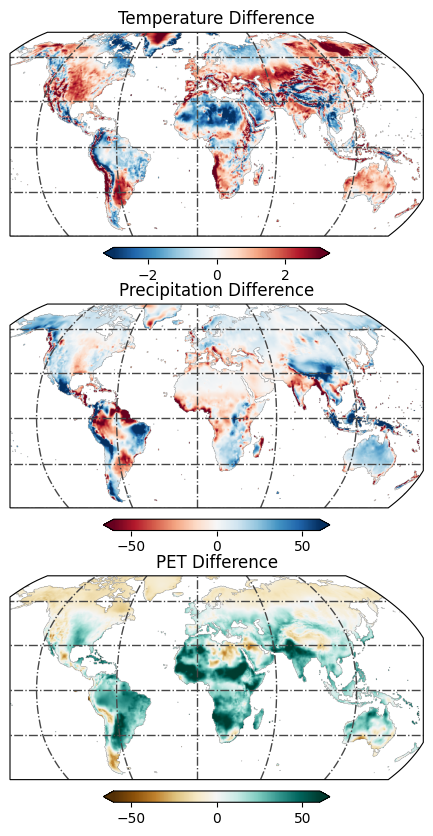

In [60]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), subplot_kw={'projection': projection})
plot_stretch_map(ax[0], np.nanmean(gcm_tas - cru_tas, axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[1], np.nanmean(gcm_pr - cru_pr, axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[2], np.nanmean(gcm_pet - cru_pet, axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')
plt.savefig("../images/gcm_assessment_bc/global_historical_mean_difference_ds.pdf")

## 偏差矫正前，全球格点，多年平均，各气候模式与cru的偏差地图

In [82]:
gcms_list = ["ACCESS_CM2", "ACCESS_ESM1_5", "CanESM5", "CAS_ESM2_0", "CNRM_CM6_1", "EC_Earth3", "EC_Earth3_Veg_LR", "FGOALS_g3", "FIO_ESM_2_0", "GFDL_ESM4", "GISS_E2_1_G", "GISS_E2_1_H", "INM_CM4_8", "INM_CM5_0", "IPSL_CM6A_LR", "MIROC6", "MPI_ESM1_2_HR", "MPI_ESM1_2_LR", "MRI_ESM2_0", "NorESM2_LM", "NorESM2_MM"]
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy")
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy")
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy")

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

fig1, ax1 = plt.subplots(7, 3, figsize=(18, 24), subplot_kw={'projection': projection})
fig2, ax2 = plt.subplots(7, 3, figsize=(18, 24), subplot_kw={'projection': projection})
fig3, ax3 = plt.subplots(7, 3, figsize=(18, 24), subplot_kw={'projection': projection})

for g in trange(21):
    gcm = gcms_list[g]
    try:
        gcm_pr  = np.load(f"H:/CMIP6/Processed/DS/{gcm}/1_pr_{gcm}_historical_DS_cdo_bl_050.npy")
        gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
    except:
        gcm_pr  = cru_pr.copy() + 0

    try:
        gcm_tas = np.load(f"H:/CMIP6/Processed/DS/{gcm}/1_tas_{gcm}_historical_DS_cdo_bl_050.npy")
        gcm_tas = gcm_tas[1212:1980].astype(np.float32) - 273.15
    except:
        gcm_tas = cru_tas.copy() + 0

    try:
        gcm_pet = np.load(f"H:/CMIP6/Processed/DS/{gcm}/1_pet_{gcm}_historical_pm_050.npy")
        gcm_pet = gcm_pet[1212:1980].astype(np.float32)
    except:
        gcm_pet = cru_pet.copy() + 0

    plot_stretch_map(ax1[g//3, g%3], np.nanmean(gcm_tas - cru_tas, axis=0), f'{gcm} Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
    plot_stretch_map(ax2[g//3, g%3], np.nanmean(gcm_pr - cru_pr, axis=0), f'{gcm} Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
    plot_stretch_map(ax3[g//3, g%3], np.nanmean(gcm_pet - cru_pet, axis=0), f'{gcm} PET Difference', -60, 60, cmap='BrBG', extend='both')
fig1.savefig("../images/gcm_assessment_bc/individual_gcm_historical_mean_difference_ds_tas.pdf")
fig2.savefig("../images/gcm_assessment_bc/individual_gcm_historical_mean_difference_ds_pr.pdf")
fig3.savefig("../images/gcm_assessment_bc/individual_gcm_historical_mean_difference_ds_pet.pdf")
fig1.clf()
fig2.clf()
fig3.clf()

  0%|          | 0/21 [00:00<?, ?it/s]

<Figure size 1800x2400 with 0 Axes>

<Figure size 1800x2400 with 0 Axes>

<Figure size 1800x2400 with 0 Axes>

## 偏差矫正前，全球格点，多年平均，多模式平均tas/pr/pet与cru的季节偏差模式地图

In [ ]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

cru_pr  = np.nanmean(cru_pr.reshape(int(cru_pr.shape[0] / 12), 12, cru_pr.shape[1], cru_pr.shape[2]), axis=0)
cru_tas = np.nanmean(cru_tas.reshape(int(cru_tas.shape[0] / 12), 12, cru_tas.shape[1], cru_tas.shape[2]), axis=0)
cru_pet = np.nanmean(cru_pet.reshape(int(cru_pet.shape[0] / 12), 12, cru_pet.shape[1], cru_pet.shape[2]), axis=0)

gcm_pr  = np.load("../data/mme/pr_ds/pr_historical_ds_mme.npy", mmap_mode='r')
gcm_tas = np.load("../data/mme/tas_ds/tas_historical_ds_mme.npy", mmap_mode='r')
gcm_pet = np.load("../data/mme/pet_ds/pet_historical_ds_mme.npy", mmap_mode='r')

gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
gcm_tas = gcm_tas[1212:1980].astype(np.float32)
gcm_pet = gcm_pet[1212:1980].astype(np.float32)

gcm_pr  = np.nanmean(gcm_pr.reshape(int(gcm_pr.shape[0] / 12), 12, gcm_pr.shape[1], gcm_pr.shape[2]), axis=0)
gcm_tas = np.nanmean(gcm_tas.reshape(int(gcm_tas.shape[0] / 12), 12, gcm_tas.shape[1], gcm_tas.shape[2]), axis=0)
gcm_pet = np.nanmean(gcm_pet.reshape(int(gcm_pet.shape[0] / 12), 12, gcm_pet.shape[1], gcm_pet.shape[2]), axis=0)

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
plot_stretch_map(ax[0, 0], np.nanmean(gcm_tas[[0, 1, 11], :, :] - cru_tas[[0, 1, 11], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[0, 1], np.nanmean(gcm_pr[[0, 1, 11], :, :] - cru_pr[[0, 1, 11], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[0, 2], np.nanmean(gcm_pet[[0, 1, 11], :, :] - cru_pet[[0, 1, 11], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plot_stretch_map(ax[1, 0], np.nanmean(gcm_tas[[2, 3, 4], :, :] - cru_tas[[2, 3, 4], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[1, 1], np.nanmean(gcm_pr[[2, 3, 4], :, :] - cru_pr[[2, 3, 4], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[1, 2], np.nanmean(gcm_pet[[2, 3, 4], :, :] - cru_pet[[2, 3, 4], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plot_stretch_map(ax[2, 0], np.nanmean(gcm_tas[[5, 6, 7], :, :] - cru_tas[[5, 6, 7], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[2, 1], np.nanmean(gcm_pr[[5, 6, 7], :, :] - cru_pr[[5, 6, 7], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[2, 2], np.nanmean(gcm_pet[[5, 6, 7], :, :] - cru_pet[[5, 6, 7], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plot_stretch_map(ax[3, 0], np.nanmean(gcm_tas[[8, 9, 10], :, :] - cru_tas[[8, 9, 10], :, :], axis=0), 'Temperature Difference', -3, 3, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[3, 1], np.nanmean(gcm_pr[[8, 9, 10], :, :] - cru_pr[[8, 9, 10], :, :], axis=0), 'Precipitation Difference', -60, 60, cmap='RdBu', extend='both')
plot_stretch_map(ax[3, 2], np.nanmean(gcm_pet[[8, 9, 10], :, :] - cru_pet[[8, 9, 10], :, :], axis=0), 'PET Difference', -60, 60, cmap='BrBG', extend='both')

plt.savefig("../images/gcm_assessment_bc/global_historical_seasonal_mean_difference_ds.pdf")
plt.close()

## 偏差矫正后，全球平均，各气候模式的tas/pr/pet时间序列，与cru时间序列

In [ ]:
# 读取cru数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series.resample('YS').sum()
cru_series = cru_series['1920-01-01' : '2014-12-31']

# 读取gcm数据
pr_gcm  = pd.read_csv("../data/global_mean_series/gcm_bc/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
tas_gcm = pd.read_csv("../data/global_mean_series/gcm_bc/tas/tas_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
pet_gcm = pd.read_csv("../data/global_mean_series/gcm_bc/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
pet_gcm = pet_gcm.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])

pr_gcm  = pr_gcm['1920-01-01' : '2014-12-31']
tas_gcm = tas_gcm['1920-01-01' : '2014-12-31'] / 12
pet_gcm = pet_gcm['1920-01-01' : '2014-12-31']

pr_gcm_mean  = pr_gcm.mean(axis=1)
tas_gcm_mean = tas_gcm.mean(axis=1)
pet_gcm_mean = pet_gcm.mean(axis=1)
pr_gcm_std   = pr_gcm.std(axis=1)
tas_gcm_std  = tas_gcm.std(axis=1)
pet_gcm_std  = pet_gcm.std(axis=1)

fig, ax = plt.subplots(3, 1, figsize=(8, 8))

ax[0].plot(cru_series.index.year, cru_series['tas'] / 12, color='black', label='CRU', linewidth=2)
ax[0].plot(tas_gcm_mean.index.year, tas_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[0].plot(tas_gcm.index.year, tas_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[0].fill_between(tas_gcm_mean.index.year, tas_gcm_mean - tas_gcm_std, tas_gcm_mean + tas_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[0].set_xlim(1919, 2015)

ax[1].plot(cru_series.index.year, cru_series['pr'], color='black', label='CRU', linewidth=2)
ax[1].plot(pr_gcm_mean.index.year, pr_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[1].plot(pr_gcm.index.year, pr_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[1].fill_between(pr_gcm_mean.index.year, pr_gcm_mean - pr_gcm_std, pr_gcm_mean + pr_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[1].set_xlim(1919, 2015)

ax[2].plot(cru_series.index.year, cru_series['pet'], color='black', label='CRU', linewidth=2)
ax[2].plot(pet_gcm_mean.index.year, pet_gcm_mean, color='red', label='GCM Mean', linewidth=2)
ax[2].plot(pet_gcm.index.year, pet_gcm.values, color='gray', linewidth=1, alpha=0.4, zorder=0)
ax[2].fill_between(pet_gcm_mean.index.year, pet_gcm_mean - pet_gcm_std, pet_gcm_mean + pet_gcm_std, color='red', alpha=0.3, label='GCM Std Dev')
ax[2].set_xlim(1919, 2015)

plt.savefig("../images/gcm_assessment_bc/global_historical_mean_series_bc.pdf")

## 偏差矫正后，全球格点，多年平均，多模式平均tas/pr/pet与cru的偏差地图

In [33]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[600:1368].astype(np.float32) # 1951-2014
cru_tas = cru_tas[600:1368].astype(np.float32) # 1951-2014
cru_pet = cru_pet[600:1368].astype(np.float32) # 1951-2014

gcm_pr  = np.load("../data/mme/pr_bc/pr_historical_bc_mme.npy", mmap_mode='r')
gcm_tas = np.load("../data/mme/tas_bc/tas_historical_bc_mme.npy", mmap_mode='r')
gcm_pet = np.load("../data/mme/pet_bc/pet_historical_bc_mme.npy", mmap_mode='r')

gcm_pr  = gcm_pr[1212:1980].astype(np.float32)
gcm_tas = gcm_tas[1212:1980].astype(np.float32)
gcm_pet = gcm_pet[1212:1980].astype(np.float32)

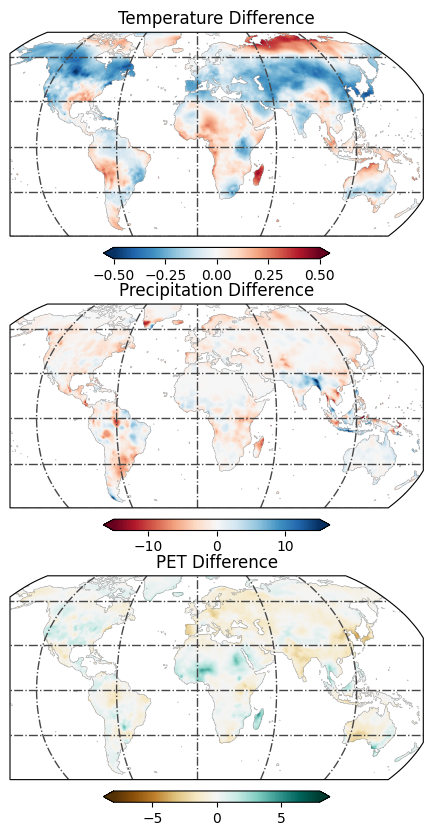

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(8, 10), subplot_kw={'projection': projection})
plot_stretch_map(ax[0], np.nanmean(gcm_tas - cru_tas, axis=0), 'Temperature Difference', -0.5, 0.5, cmap='RdBu_r', extend='both')
plot_stretch_map(ax[1], np.nanmean(gcm_pr - cru_pr, axis=0), 'Precipitation Difference', -15, 15, cmap='RdBu', extend='both')
plot_stretch_map(ax[2], np.nanmean(gcm_pet - cru_pet, axis=0), 'PET Difference', -8, 8, cmap='BrBG', extend='both')
plt.savefig("../images/gcm_assessment_bc/global_historical_mean_difference_bc.pdf")

# 未来气候状况变化

## 历史和未来情景下的全球平均气候序列图

In [ ]:
# 定义变量、情景和颜色
element = "pet"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
# colors_list = ['#153559', '#67BED0', '#3BA38F', '#3E5382', '#DF6155']
# colors_list = ['#153559', '#08A8CD', '#F39608', '#D80D1F', '#9A191D']
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取cru数据和gcm数据
all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
cru_series = all_cru_series[element].resample('YS').sum()
cru_mean = cru_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/gcm_bc/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "tas":
    gcm_historical = gcm_historical / 12
    cru_series     = cru_series / 12
    gcm_historical['1998-01-01':'2004-12-31'] = gcm_historical['1998-01-01':'2004-12-31'] - 0.1
    gcm_historical['2005-01-01':] = gcm_historical['2005-01-01':] - 0.2
    cru_mean = cru_mean / 12
gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.7

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制cru序列
ax[0].plot(cru_series.index, cru_series.values, label='CRU Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(cru_series['1981-01-01':'2022-12-31'].index, [cru_mean]*len(cru_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/gcm_bc/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    if element == "pet":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen - 4
    if element == "pr":
        gcm_scen = gcm_scen - 5
    if element == "tas":
        gcm_scen = gcm_scen / 12
        gcm_scen = gcm_scen - 0.3
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 1.3, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = cru_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Global Mean Precipitation (mm/year)')
ax[0].set_title('Global Mean Precipitation Time Series from CRU and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - cru_mean, ymax - cru_mean])
else:
    ax[1].set_ylim([(ymin - cru_mean) / cru_mean * 100, (ymax - cru_mean) / cru_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
plt.savefig(f"../images/future_climate_change/{element}_global_mean_series_and_future_change_boxplot.pdf")

## 未来三种情景的全球平均变化地图

In [110]:
cru_pr  = np.load("../../2025_04_Params_Transplant/Data/forcing/pr_cru_1901_2022.npy", mmap_mode='r')
cru_tas = np.load("../../2025_04_Params_Transplant/Data/forcing/tas_cru_1901_2022.npy", mmap_mode='r')
cru_pet = np.load("../../2025_04_Params_Transplant/Data/forcing/pet_cru_1901_2022.npy", mmap_mode='r')

cru_pr  = cru_pr[960:].astype(np.float32) # 1981-2022
cru_tas = cru_tas[960:].astype(np.float32) # 1981-2022
cru_pet = cru_pet[960:].astype(np.float32) # 1981-2022

cru_pr  = np.nanmean(cru_pr.reshape(int(cru_pr.shape[0] / 12), 12, cru_pr.shape[1], cru_pr.shape[2]), axis=(0, 1)) * 12
cru_tas = np.nanmean(cru_tas.reshape(int(cru_tas.shape[0] / 12), 12, cru_tas.shape[1], cru_tas.shape[2]), axis=(0, 1))
cru_pet = np.nanmean(cru_pet.reshape(int(cru_pet.shape[0] / 12), 12, cru_pet.shape[1], cru_pet.shape[2]), axis=(0, 1)) * 12

In [ ]:
fig1, ax1 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
fig2, ax2 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
fig3, ax3 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})

scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for s in trange(4):
    scen = scen_list[s]

    gcm_pr  = np.load(f"../data/mme/pr_bc/pr_{scen}_bc_mme.npy", mmap_mode='r')
    gcm_tas = np.load(f"../data/mme/tas_bc/tas_{scen}_bc_mme.npy", mmap_mode='r')
    gcm_pet = np.load(f"../data/mme/pet_bc/pet_{scen}_bc_mme.npy", mmap_mode='r')

    gcm_pr  = gcm_pr[:].astype(np.float32)
    gcm_tas = gcm_tas[:].astype(np.float32)
    gcm_pet = gcm_pet[:].astype(np.float32)

    gcm_pr  = np.nanmean(gcm_pr.reshape(int(gcm_pr.shape[0] / 12), 12, gcm_pr.shape[1], gcm_pr.shape[2]), axis=1) * 12 - 5
    gcm_tas = np.nanmean(gcm_tas.reshape(int(gcm_tas.shape[0] / 12), 12, gcm_tas.shape[1], gcm_tas.shape[2]), axis=1) - 0.3
    gcm_pet = np.nanmean(gcm_pet.reshape(int(gcm_pet.shape[0] / 12), 12, gcm_pet.shape[1], gcm_pet.shape[2]), axis=1) * 12 - 4

    plot_stretch_map(ax1[s, 0], np.nanmean(gcm_tas[17:37], axis=0) - cru_tas, f'{scen.upper()} NF tas Change', 0, 4, cmap='OrRd', extend='max', alpha=1)
    plot_stretch_map(ax1[s, 1], np.nanmean(gcm_tas[37:57], axis=0) - cru_tas, f'{scen.upper()} MF tas Change', 0, 4, cmap='OrRd', extend='max', alpha=1)
    plot_stretch_map(ax1[s, 2], np.nanmean(gcm_tas[57:77], axis=0) - cru_tas, f'{scen.upper()} FF tas Change', 0, 4, cmap='OrRd', extend='max', alpha=1)

    plot_stretch_map(ax2[s, 0], 100 * (np.nanmean(gcm_pr[17:37], axis=0) - cru_pr) / cru_pr, f'{scen.upper()} NF pr Change', -30, 30, cmap='RdBu', extend='both')
    plot_stretch_map(ax2[s, 1], 100 * (np.nanmean(gcm_pr[37:57], axis=0) - cru_pr) / cru_pr, f'{scen.upper()} MF pr Change', -30, 30, cmap='RdBu', extend='both')
    plot_stretch_map(ax2[s, 2], 100 * (np.nanmean(gcm_pr[57:77], axis=0) - cru_pr) / cru_pr, f'{scen.upper()} FF pr Change', -30, 30, cmap='RdBu', extend='both')

    plot_stretch_map(ax3[s, 0], 100 * (np.nanmean(gcm_pet[17:37], axis=0) - cru_pet) / cru_pet, f'{scen.upper()} NF pet Change', -30, 30, cmap='BrBG', extend='both')
    plot_stretch_map(ax3[s, 1], 100 * (np.nanmean(gcm_pet[37:57], axis=0) - cru_pet) / cru_pet, f'{scen.upper()} MF pet Change', -30, 30, cmap='BrBG', extend='both')
    plot_stretch_map(ax3[s, 2], 100 * (np.nanmean(gcm_pet[57:77], axis=0) - cru_pet) / cru_pet, f'{scen.upper()} FF pet Change', -30, 30, cmap='BrBG', extend='both')
fig1.savefig("../images/future_climate_change/tas_future_change_bc.pdf")
fig2.savefig("../images/future_climate_change/pr_future_change_bc.pdf")
fig3.savefig("../images/future_climate_change/pet_future_change_bc.pdf")
# fig1.clf()
# fig2.clf()
# fig3.clf()

## 未来天然径流数据集

### 历史未来天然径流序列

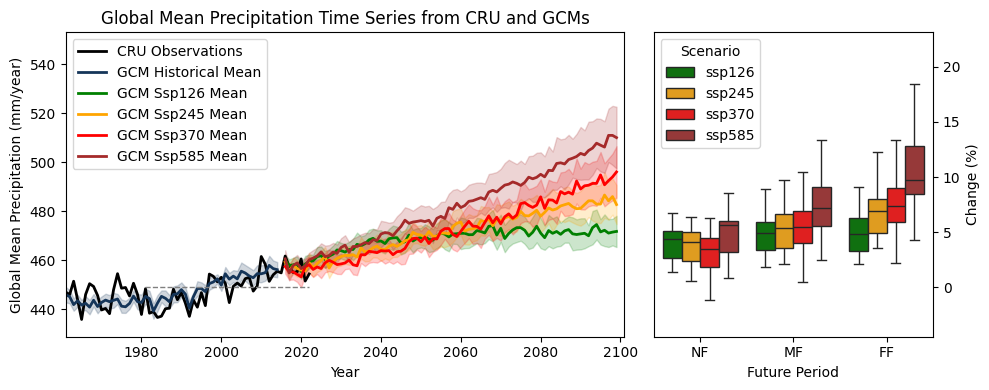

In [16]:
# 定义变量、情景和颜色
element = "actural_evaporation"
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
colors_list = ['#153559', 'green', 'orange', 'red', 'brown']

future_period = {'NF': pd.date_range(start='2031-01-01', end='2050-12-31', freq='MS'),
                 'MF': pd.date_range(start='2051-01-01', end='2070-12-31', freq='MS'),
                 'FF': pd.date_range(start='2071-01-01', end='2090-12-31', freq='MS')
                 }
future_change = []

# 读取cru数据和gcm数据
FNRD_data = np.load(f"../../2025_04_Params_Transplant/Results/GNRD/{element}_GNRD.npy").astype(np.float32)
FNRD_data[0] = FNRD_data[1]
FNRD_data[np.isinf(FNRD_data)] = np.nan
cru_series = pd.Series(np.nanmean(FNRD_data, axis=(1, 2)), index=pd.date_range(start='1901-01-01', end='2022-12-31', freq='MS')).resample('YS').sum()
cru_mean = cru_series['1981-01-01':'2022-12-31'].mean()

gcm_historical = pd.read_csv(f"../data/global_mean_series/FNRD/{element}/{element}_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
if element == "natural_runoff":
    gcm_historical = gcm_historical + 20
if element == "actural_evaporation":
    gcm_historical = gcm_historical - 3

gcm_historical_mean = gcm_historical.mean(axis=1)
gcm_historical_std  = gcm_historical.std(axis=1)

scale_range = 0.5

# 绘图
fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 1]})

# 绘制cru序列
ax[0].plot(cru_series.index, cru_series.values, label='CRU Observations', color='black', linewidth=2)
ax[0].plot(gcm_historical_mean.index, gcm_historical_mean.values, label='GCM Historical Mean', color=colors_list[0], linewidth=2)
ax[0].fill_between(gcm_historical_mean.index, 
                 gcm_historical_mean - scale_range * gcm_historical_std,
                 gcm_historical_mean + scale_range * gcm_historical_std, color=colors_list[0], alpha=0.2)
# 绘制平均序列
ax[0].plot(cru_series['1981-01-01':'2022-12-31'].index, [cru_mean]*len(cru_series['1981-01-01':'2022-12-31']), color='gray', linewidth=1, linestyle='--')

# 绘制未来序列，计算未来相较于历史的变化
for i, scen in enumerate(scen_list[1:]):
    gcm_scen = pd.read_csv(f"../data/global_mean_series/FNRD/{element}/{element}_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum(min_count=1)
    gcm_scen[np.isinf(gcm_scen)] = np.nan
    if element == "natural_runoff":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen = gcm_scen + 7
        gcm_scen.iloc[0, :] = np.nan
    if element == "actural_evaporation":
        gcm_scen = gcm_scen.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR'])
        gcm_scen.iloc[0, :] = np.nan
        gcm_scen = gcm_scen - 7
    gcm_scen_mean = gcm_scen.mean(axis=1)
    gcm_scen_std  = gcm_scen.std(axis=1)

    scale_range_series = np.linspace(scale_range - 0.1, 0.6, len(gcm_scen_mean))

    ax[0].plot(gcm_scen_mean.index, gcm_scen_mean.values, label=f'GCM {scen.capitalize()} Mean', linewidth=2, color=colors_list[i + 1])
    ax[0].fill_between(gcm_scen_mean.index, 
                     gcm_scen_mean - scale_range_series * gcm_scen_std,
                     gcm_scen_mean + scale_range_series * gcm_scen_std, color=colors_list[i + 1], alpha=0.2)
    
    for period_name, period_range in future_period.items():
        for gcm in gcm_scen.columns:
            gcm_mean = gcm_scen[gcm][period_range[0] : period_range[-1]].mean()
            hist_mean = cru_mean
            if element == "tas":
                change = gcm_mean - hist_mean
            else:
                change = ((gcm_mean - hist_mean) / hist_mean) * 100
            future_change.append({'Scenario': scen, 'Period': period_name, 'Change (%)': change, 'GCM': gcm})
    
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Global Mean Precipitation (mm/year)')
ax[0].set_title('Global Mean Precipitation Time Series from CRU and GCMs')
ax[0].legend()
ax[0].set_xlim([pd.Timestamp('1961-01-01'), pd.Timestamp('2100-12-31')])
ymin, ymax = ax[0].get_ylim()

# 绘制未来变化箱线图
future_change_df = pd.DataFrame(future_change)
sns.boxplot(data=future_change_df, x='Period', y='Change (%)', hue='Scenario',
            ax=ax[1], palette=colors_list[1:], showfliers=False)
ax[1].set_ylabel('Change (%)')
ax[1].set_xlabel('Future Period')
if element == "tas":
    ax[1].set_ylim([ymin - cru_mean, ymax - cru_mean])
else:
    ax[1].set_ylim([(ymin - cru_mean) / cru_mean * 100, (ymax - cru_mean) / cru_mean * 100])
# 将 ax[1] 的 y 轴刻度和标签移动到右侧
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_ticks_position('right')
ax[1].tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.tight_layout()
plt.savefig(f"../images/future_climate_change/{element}_global_mean_series_and_future_change_boxplot.pdf")

### 未来情景相对于历史的变化地图

In [22]:
cru_nr = np.load("../../2025_04_Params_Transplant/Results/GNRD/natural_runoff_GNRD.npy", mmap_mode='r')
cru_ae = np.load("../../2025_04_Params_Transplant/Results/GNRD/actural_evaporation_GNRD.npy", mmap_mode='r')

cru_nr = cru_nr[960:].astype(np.float32) # 1981-2022
cru_ae = cru_ae[960:].astype(np.float32) # 1981-2022

cru_nr = np.nanmean(cru_nr.reshape(int(cru_nr.shape[0] / 12), 12, cru_nr.shape[1], cru_nr.shape[2]), axis=(0, 1)) * 12
cru_ae = np.nanmean(cru_ae.reshape(int(cru_ae.shape[0] / 12), 12, cru_ae.shape[1], cru_ae.shape[2]), axis=(0, 1)) * 12

In [28]:
fig1, ax1 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})
fig2, ax2 = plt.subplots(4, 3, figsize=(15, 12), subplot_kw={'projection': projection})

scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
for s in trange(4):
    scen = scen_list[s]

    gcm_nr = np.load(f"../data/mme/natural_runoff/natural_runoff_{scen}_mme.npy", mmap_mode='r')
    gcm_ae = np.load(f"../data/mme/actural_evaporation/actural_evaporation_{scen}_mme.npy", mmap_mode='r')

    gcm_nr = gcm_nr[:].astype(np.float32)
    gcm_ae = gcm_ae[:].astype(np.float32)

    gcm_nr[0] = gcm_nr[1]
    gcm_ae[0] = gcm_ae[1]

    gcm_nr = np.nanmean(gcm_nr.reshape(int(gcm_nr.shape[0] / 12), 12, gcm_nr.shape[1], gcm_nr.shape[2]), axis=1) * 12 + 7
    gcm_ae = np.nanmean(gcm_ae.reshape(int(gcm_ae.shape[0] / 12), 12, gcm_ae.shape[1], gcm_ae.shape[2]), axis=1) * 12 - 20

    plot_stretch_map(ax1[s, 0], 100 * (np.nanmean(gcm_nr[17:37], axis=0) - cru_nr) / cru_nr, f'{scen.upper()} NF pr Change', -50, 50, cmap='RdBu', extend='both')
    plot_stretch_map(ax1[s, 1], 100 * (np.nanmean(gcm_nr[37:57], axis=0) - cru_nr) / cru_nr, f'{scen.upper()} MF pr Change', -50, 50, cmap='RdBu', extend='both')
    plot_stretch_map(ax1[s, 2], 100 * (np.nanmean(gcm_nr[57:77], axis=0) - cru_nr) / cru_nr, f'{scen.upper()} FF pr Change', -50, 50, cmap='RdBu', extend='both')

    plot_stretch_map(ax2[s, 0], 100 * (np.nanmean(gcm_ae[17:37], axis=0) - cru_ae) / cru_ae, f'{scen.upper()} NF ae Change', -50, 50, cmap='BrBG', extend='both')
    plot_stretch_map(ax2[s, 1], 100 * (np.nanmean(gcm_ae[37:57], axis=0) - cru_ae) / cru_ae, f'{scen.upper()} MF ae Change', -50, 50, cmap='BrBG', extend='both')
    plot_stretch_map(ax2[s, 2], 100 * (np.nanmean(gcm_ae[57:77], axis=0) - cru_ae) / cru_ae, f'{scen.upper()} FF ae Change', -50, 50, cmap='BrBG', extend='both')

fig1.savefig("../images/future_climate_change/nr_future_change.pdf")
fig2.savefig("../images/future_climate_change/pr_future_change.pdf")

fig1.clf()
fig2.clf()

  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

### 未来情景不同分量的趋势

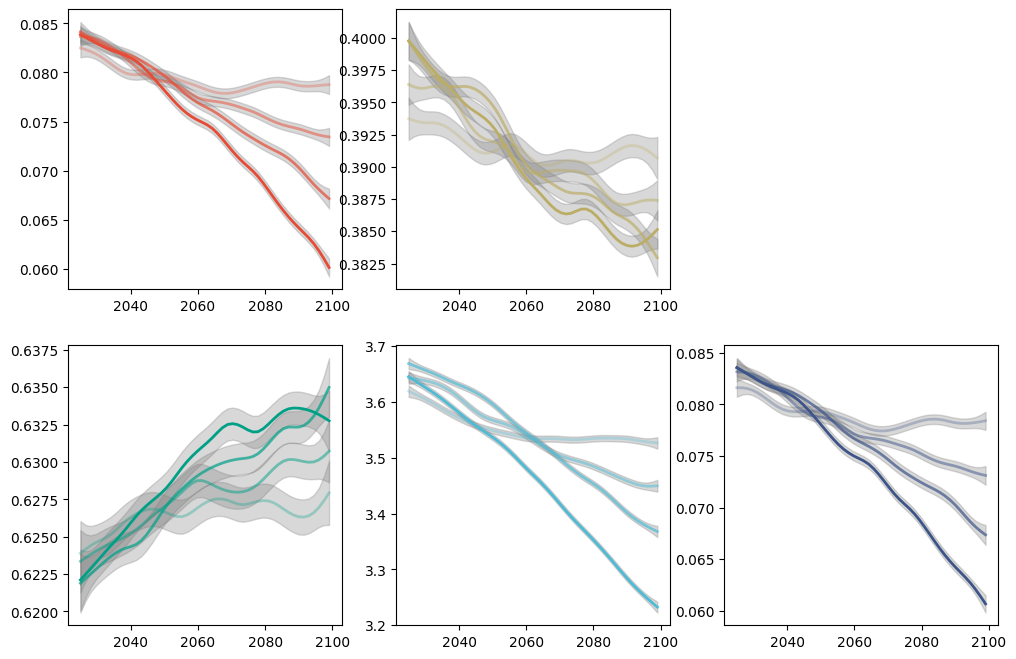

In [26]:
def get_gam_fit(x, y, interp_num=1000):
    gam = LinearGAM(s(0)).fit(x, y)
    x_pred = np.linspace(x.min(), x.max(), interp_num)
    y_pred = gam.predict(x_pred)
    y_lower, y_upper = gam.confidence_intervals(x_pred, width=0.90).T
    return x_pred, y_pred, y_lower, y_upper

def plot_gcm_series(ax, x, y, color='blue', alpha=1):
    interp_num = 50
    x_pred, y_pred, y_lower, y_upper = get_gam_fit(x.year.values, y.values, interp_num=interp_num)
    ax.plot(x_pred, y_pred, color=color, linewidth=2, alpha=alpha)
    ax.fill_between(x_pred, y_lower, y_upper, color='gray', alpha=0.3)

scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
colors_list = ['#E64B35', '#BCAD66', '#00A087', '#4DBBD5', '#3C5488']
alpha_list = [0.3, 0.5, 0.7, 1]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 2].remove()

for sc in range(len(scen_list)):
    scen = scen_list[sc]
    pr_fp  = f"../data/global_mean_series/gcm_bc/pr/pr_{scen}_global_mean_series.txt"
    psn_fp = f"../data/global_mean_series/FNRD/snow_fall/snow_fall_{scen}_global_mean_series.txt"
    nr_fp  = f"../data/global_mean_series/FNRD/natural_runoff/natural_runoff_{scen}_global_mean_series.txt"
    ae_fp  = f"../data/global_mean_series/FNRD/actural_evaporation/actural_evaporation_{scen}_global_mean_series.txt"
    s_fp   = f"../data/global_mean_series/FNRD/soil_moisture/soil_moisture_{scen}_global_mean_series.txt"
    sm_fp  = f"../data/global_mean_series/FNRD/snow_melt/snow_melt_{scen}_global_mean_series.txt"
    all_pr  = pd.read_csv(pr_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_psn = pd.read_csv(psn_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_nr  = pd.read_csv(nr_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_ae  = pd.read_csv(ae_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_s   = pd.read_csv(s_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_sm  = pd.read_csv(sm_fp, sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
    all_pr  = all_pr.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_psn = all_psn.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_nr  = all_nr.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_ae  = all_ae.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_s   = all_s.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])
    all_sm  = all_sm.drop(columns=['MPI_ESM1_2_HR', 'MPI_ESM1_2_LR', 'FIO_ESM_2_0'])

    plot_gcm_series(ax[0, 0], all_psn.index[10:], all_psn.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[0], alpha=alpha_list[sc])
    plot_gcm_series(ax[0, 1], all_nr.index[10:], all_nr.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[1], alpha=alpha_list[sc])
    plot_gcm_series(ax[1, 0], all_ae.index[10:], all_ae.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[2], alpha=alpha_list[sc])
    plot_gcm_series(ax[1, 1], all_s.index[10:], all_s.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[3], alpha=alpha_list[sc])
    plot_gcm_series(ax[1, 2], all_sm.index[10:], all_sm.mean(axis=1)[10:] / all_pr.mean(axis=1)[10:], color=colors_list[4], alpha=alpha_list[sc])

# plt.savefig("../images/future_climate_change/future_runoff_components.pdf")
# plt.close()

### 全球尺度，四种情景下，三个时期的平均情况相较于基准期在Budyko空间中的运动情况

In [28]:
def cal_angle_change(x1, y1, x2, y2):
    angle1 = np.arctan2(y1, x1)
    angle2 = np.arctan2(y2, x2)
    angle_change = np.degrees(angle2 - angle1)

    if x2 - x1 >= 0:
        angle_change = 90 - angle_change
    else:
        angle_change = 270 - angle_change

    intense_change = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return angle_change, intense_change

gcms_list = ["ACCESS_CM2", "ACCESS_ESM1_5", "CanESM5", "CAS_ESM2_0", "CNRM_CM6_1", "EC_Earth3", "EC_Earth3_Veg_LR", "FGOALS_g3", "GFDL_ESM4", "GISS_E2_1_G", "GISS_E2_1_H", "INM_CM4_8", "INM_CM5_0", "IPSL_CM6A_LR", "MIROC6", "MRI_ESM2_0", "NorESM2_LM", "NorESM2_MM"]
scen_list = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

# all_cru_series = pd.read_csv("../data/global_mean_series/cru/cru_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')
# all_gleam_series = pd.read_csv("../data/global_mean_series/gleam/gleam_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time')

# hist_pr  = all_cru_series['pr'].resample('YS').sum()['1981-01-01':'2022-12-31'].mean()
# hist_pet = all_cru_series['pet'].resample('YS').sum()['1981-01-01':'2022-12-31'].mean()
# hist_ae  = all_gleam_series['AE'].resample('YS').sum()['1981-01-01':'2022-12-31'].mean()
# hist_x = hist_pet / hist_pr
# hist_y  = hist_ae / hist_pr

all_hist_pr  = pd.read_csv(f"../data/global_mean_series/gcm_bc/pr/pr_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
all_hist_pet = pd.read_csv(f"../data/global_mean_series/gcm_bc/pet/pet_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum()
all_hist_ae  = pd.read_csv(f"../data/global_mean_series/FNRD/actural_evaporation/actural_evaporation_historical_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 3

hist_pr  = all_hist_pr[gcms_list].mean(axis=1)['1981-01-01':'2022-12-31'].mean()
hist_pet = all_hist_pet[gcms_list].mean(axis=1)['1981-01-01':'2022-12-31'].mean()
hist_ae  = all_hist_ae[gcms_list].mean(axis=1)['1981-01-01':'2022-12-31'].mean()
hist_x = hist_pet / hist_pr
hist_y  = hist_ae / hist_pr

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

ax[0].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)
ax[1].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)
ax[2].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)
ax[3].scatter(hist_x, hist_y, color='black', s=100, label='historical', zorder=5)


for sc in range(len(scen_list)):
    scen = scen_list[sc]
    results = np.full((len(gcms_list), 6), np.nan)
    gcms_pr  = pd.read_csv(f"../data/global_mean_series/gcm_bc/pr/pr_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 4
    gcms_pet = pd.read_csv(f"../data/global_mean_series/gcm_bc/pet/pet_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 5
    gcms_ae  = pd.read_csv(f"../data/global_mean_series/FNRD/actural_evaporation/actural_evaporation_{scen}_global_mean_series.txt", sep='\t', parse_dates=['Time'], index_col='Time').resample('YS').sum() - 3

    for g in range(len(gcms_list)):
        gcm = gcms_list[g]
        gcm_pr_NF = gcms_pr[gcm]['2031-01-01':'2050-12-31'].mean()
        gcm_pr_MF = gcms_pr[gcm]['2051-01-01':'2070-12-31'].mean()
        gcm_pr_FF = gcms_pr[gcm]['2071-01-01':'2090-12-31'].mean()

        gcm_pet_NF = gcms_pet[gcm]['2031-01-01':'2050-12-31'].mean()
        gcm_pet_MF = gcms_pet[gcm]['2051-01-01':'2070-12-31'].mean()
        gcm_pet_FF = gcms_pet[gcm]['2071-01-01':'2090-12-31'].mean()

        gcm_ae_NF = gcms_ae[gcm]['2031-01-01':'2050-12-31'].mean()
        gcm_ae_MF = gcms_ae[gcm]['2051-01-01':'2070-12-31'].mean()
        gcm_ae_FF = gcms_ae[gcm]['2071-01-01':'2090-12-31'].mean()

        gcm_x_NF = gcm_pet_NF / gcm_pr_NF
        gcm_x_MF = gcm_pet_MF / gcm_pr_MF
        gcm_x_FF = gcm_pet_FF / gcm_pr_FF
        gcm_y_NF = gcm_ae_NF / gcm_pr_NF
        gcm_y_MF = gcm_ae_MF / gcm_pr_MF
        gcm_y_FF = gcm_ae_FF / gcm_pr_FF

        angle_change_NF, intense_change_NF = cal_angle_change(hist_x, hist_y, gcm_x_NF, gcm_y_NF)
        angle_change_MF, intense_change_MF = cal_angle_change(hist_x, hist_y, gcm_x_MF, gcm_y_MF)
        angle_change_FF, intense_change_FF = cal_angle_change(hist_x, hist_y, gcm_x_FF, gcm_y_FF)

        results[g, :] = [angle_change_NF, intense_change_NF, angle_change_MF, intense_change_MF, angle_change_FF, intense_change_FF]
    results_df = pd.DataFrame(results, index=gcms_list, columns=['Angle_Change_NF', 'Intense_Change_NF', 'Angle_Change_MF', 'Intense_Change_MF', 'Angle_Change_FF', 'Intense_Change_FF'])
    results_df.to_csv(f"../results/budyko_move_global/budyko_move_global_{scen}.txt", sep='\t', float_format='%.2f')

    gcm_pr_mean  = gcms_pr[gcms_list].mean(axis=1)
    gcm_pet_mean = gcms_pet[gcms_list].mean(axis=1)
    gcm_ae_mean  = gcms_ae[gcms_list].mean(axis=1)

    gcm_pr_mean_NF = gcm_pr_mean['2031-01-01':'2050-12-31'].mean()
    gcm_pr_mean_MF = gcm_pr_mean['2051-01-01':'2070-12-31'].mean()
    gcm_pr_mean_FF = gcm_pr_mean['2071-01-01':'2090-12-31'].mean()
    gcm_pet_mean_NF = gcm_pet_mean['2031-01-01':'2050-12-31'].mean()
    gcm_pet_mean_MF = gcm_pet_mean['2051-01-01':'2070-12-31'].mean()
    gcm_pet_mean_FF = gcm_pet_mean['2071-01-01':'2090-12-31'].mean()
    gcm_ae_mean_NF = gcm_ae_mean['2031-01-01':'2050-12-31'].mean()
    gcm_ae_mean_MF = gcm_ae_mean['2051-01-01':'2070-12-31'].mean()
    gcm_ae_mean_FF = gcm_ae_mean['2071-01-01':'2090-12-31'].mean()
    gcm_x_mean_NF = gcm_pet_mean_NF / gcm_pr_mean_NF
    gcm_x_mean_MF = gcm_pet_mean_MF / gcm_pr_mean_MF
    gcm_x_mean_FF = gcm_pet_mean_FF / gcm_pr_mean_FF
    gcm_y_mean_NF = gcm_ae_mean_NF / gcm_pr_mean_NF
    gcm_y_mean_MF = gcm_ae_mean_MF / gcm_pr_mean_MF
    gcm_y_mean_FF = gcm_ae_mean_FF / gcm_pr_mean_FF

    ax[sc].scatter(gcm_x_mean_NF, gcm_y_mean_NF, color='red', s=100, label='NF Mean', zorder=5)
    ax[sc].scatter(gcm_x_mean_MF, gcm_y_mean_MF, color='orange', s=100, label='MF Mean', zorder=5)
    ax[sc].scatter(gcm_x_mean_FF, gcm_y_mean_FF, color='blue', s=100, label='FF Mean', zorder=5)
plt.savefig("../images/future_climate_change/budyko_move_global_scatter.pdf")
plt.close()

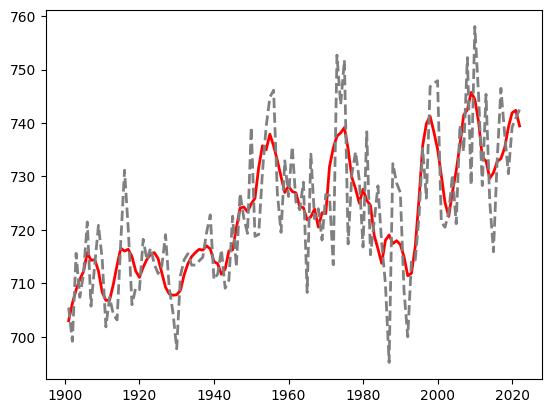

In [ ]:
y_smooth = savgol_filter(cru_series.values, window_length=10, polyorder=3)
plt.plot(cru_series.index, y_smooth, label = 'smoothed CRU', color='red', linewidth=2)
plt.plot(cru_series.index, cru_series.values, label='origin CRU', color='gray', linewidth=2, linestyle='--')

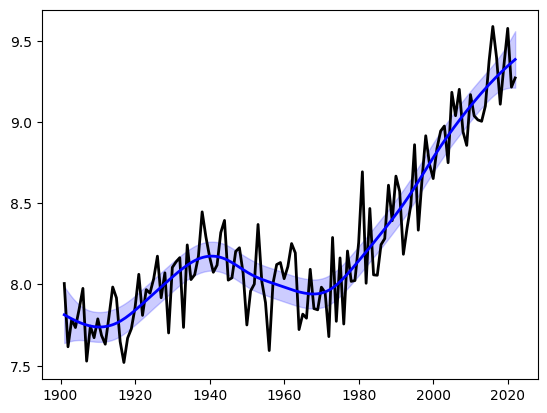

In [57]:
x = cru_series.index.year.values.astype(np.float32)
y = cru_series.values
gam = LinearGAM(s(0)).fit(x, y)
x_pred = np.linspace(x.min(), x.max(), 200)
y_pred = gam.predict(x_pred)
y_lower, y_upper = gam.confidence_intervals(x_pred, width=0.95).T

plt.plot(x, y, label='CRU Observations', color='black', linewidth=2)
plt.plot(x_pred, y_pred, color='blue', label='GAM Fit', linewidth=2)
plt.fill_between(x_pred, y_lower, y_upper, color='blue', alpha=0.2, label='95% Confidence Interval')

In [51]:
cru_series = cru_series['tas'].resample('YS').mean()